In [5]:
!pip3 install pyaudio
import pyaudio
import wave




In [12]:
import pyaudio
import wave

# the file name output you want to record into
filename = "recorded.wav"
# set the chunk size of 1024 samples
chunk = 1024
# sample format
FORMAT = pyaudio.paInt16
# mono, change to 2 if you want stereo
channels = 1
# 44100 samples per second
sample_rate = 44100
record_seconds = 5
# initialize PyAudio object
p = pyaudio.PyAudio()
# open stream object as input & output
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
frames = []
print("Recording...")
for i in range(int(sample_rate / chunk * record_seconds)):
    data = stream.read(chunk, exception_on_overflow = False)
    # if you want to hear your voice while recording
    # stream.write(data)
    frames.append(data)
print("Finished recording.")
# stop and close stream
stream.stop_stream()
stream.close()
# terminate pyaudio object
p.terminate()
# save audio file
# open the file in 'write bytes' mode
wf = wave.open(filename, "wb")
# set the channels
wf.setnchannels(channels)
# set the sample format
wf.setsampwidth(p.get_sample_size(FORMAT))
# set the sample rate
wf.setframerate(sample_rate)
# write the frames as bytes
wf.writeframes(b"".join(frames))
# close the file
wf.close()

Recording...
Finished recording.


<ipython-input-13-271786e608c7>:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal,np.int64)


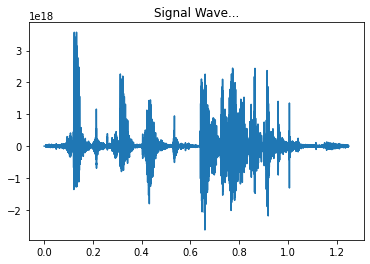

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open("recorded.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal,np.int64)
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)


Time = np.linspace(0, len(signal) / fs, num=len(signal))

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(Time, signal)
plt.show()